# **Deep Learning**

## Blink detection

## 1. PRIMARY APPROACH

Train a CNN form scratch for detecting a blink on a number of images.

### 1.1. Library import
First of all, we need to load the needed libraries: Numpy, Matplotlib, TensorFlow, Keras, Google Colab, Sklearn and Pandas .


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from google.colab import drive
from sklearn.model_selection import train_test_split

import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

# Needed for F1-Score
!pip3 install --upgrade pip
!pip3 install tfa-nightly

import tensorflow_addons as tfa


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.5/591.5 kB 36.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11586550324177170250
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14343274496
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16002046663220425484
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

Definimos la función generadora de las imágenes para cada ojo y etiquetas correspondientes:

In [ ]:
# Custom generator that returns two images of the eyes and the blink label
def generator(dataframe, datagen):
  left_eye_generator = datagen.flow_from_dataframe(dataframe=dataframe,
                                                   directory = imgs_path,
                                                   target_size =(img_width, img_height),
                                                   x_col=left_eye_col,
                                                   y_col=y_col,
                                                   class_mode="binary",
                                                   seed=seed,
                                                   batch_size=batch_size)
  right_eye_generator = datagen.flow_from_dataframe(dataframe=dataframe,
                                                    directory = imgs_path,
                                                    target_size =(img_width, img_height),
                                                    x_col=right_eye_col,
                                                    y_col=y_col,
                                                    class_mode="binary",
                                                    seed=seed,
                                                    batch_size=batch_size)
  while True:
    left_eye = left_eye_generator.next()
    left_eye_image = left_eye[0]
    label = left_eye[1]
    right_eye = right_eye_generator.next()
    right_eye_image = right_eye[0]
    yield [left_eye_image, right_eye_image], label

## 1.2. Read dataset
Next step consts of reading the dataset and the construction of a dataframe with the path to each of the images and their associated labels.

Drive is mounted to access our dataset and unzip the archive:

In [5]:
drive.mount('/content/gdrive')
!unzip -n '/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Trabajo final/RT-BENE.zip' >> /dev/null

Mounted at /content/gdrive


Now, we read the data and build the dataframe:

In [ ]:
data_path = 'RT-BENE/'
imgs_path = data_path + 'images/'
labels_path = data_path + 'blinks.csv'

seed = 100

train_data = pd.read_csv(labels_path, dtype=str)

datagen = ImageDataGenerator(rescale=1./255)

aug_datagen = ImageDataGenerator(rescale=1./255,
                                 rotation_range=20,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 brightness_range=[1,1.5])

The following cells check the class balance:

In [ ]:
print("Initially, we have the following instances per class: ")
print(train_data['blink'].value_counts())

Initially, we have the following instances per class: 
0    102793
1      4557
Name: blink, dtype: int64


Since there is a severe unbalance, it is decided to split the dataframe in two parts, one per class, so each is processed independently:

In [ ]:
blink = train_data.loc[train_data['blink']=='1'].reset_index()
no_blink = train_data.loc[train_data['blink']=='0'].reset_index()

In [ ]:
print(f"Blink instances: {blink.shape[0]}")
print(f"No blink instances: {no_blink.shape[0]}")

Blink instances: 4557
No blink instances: 102793


This unbalance will be managed with oversampling over the minor class and the inclusion of data augmentatin in the defined ImageDaraGenerator (aug_datagen):

In [ ]:
print("Blink instances per video: ")
print(blink['video'].value_counts())

Blink instances per video: 
0     931
2     789
11    692
8     459
10    353
13    295
14    215
3     167
7     149
4     130
1     128
5     110
9      45
16     42
15     29
12     23
Name: video, dtype: int64


In [ ]:
print("No blink instances per video: ")
print(no_blink['video'].value_counts())

No blink instances per video: 
10    16206
11    12125
0     11934
13     9291
1      8543
2      7913
8      5649
5      5245
14     5156
4      4620
16     4507
9      4165
3      3038
15     1781
7      1708
12      912
Name: video, dtype: int64


However, before performing the oversampling, and to avoid that training information will appear in validation and test sets, the data is firstly splitted in these 3 sets.

This will split the data maintaining the same balance between both classes, this is, there will be more examples of 'no blink' than 'blink'.

In [ ]:
train_data, test_data = train_test_split(train_data, test_size=0.3, random_state=seed, stratify=train_data['blink'])
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=seed, stratify=test_data['blink'])

train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

left_eye_col = 'left_eye'
right_eye_col = 'right_eye'
y_col = 'blink'

batch_size = 64
img_width = 60
img_height = 36

val_generator = generator(val_data, datagen)
test_generator = generator(test_data, datagen)

In [ ]:

print(f"Total number of instances in the validation dataset: {val_data.shape[0]}")
print("\nClass balance:")
print(val_data['blink'].value_counts())

Total number of instances in the validation dataset: 16102

Class balance:
0    15419
1      683
Name: blink, dtype: int64


In [ ]:
print(f"Total number of instances in the test dataset: {test_data.shape[0]}")
print("\nClass balance:")
print(test_data['blink'].value_counts())

Total number of instances in the test dataset: 16103

Class balance:
0    15419
1      684
Name: blink, dtype: int64


In [ ]:
print("Total number of validation blinks per video:")
print(val_data[val_data['blink']=='1']['video'].value_counts())

print("\nTotal number of validation no blinks per video: ")
print(val_data[val_data['blink']=='0']['video'].value_counts())

Total number of validation blinks per video:
0     127
2     125
11    113
8      60
10     57
13     43
14     32
7      26
3      24
5      20
4      19
1      15
9       9
16      6
15      5
12      2
Name: video, dtype: int64

Total number of validation no blinks per video: 
10    2496
11    1856
0     1797
13    1390
1     1279
2     1241
8      803
5      790
14     759
4      691
16     627
9      611
3      439
15     261
7      251
12     128
Name: video, dtype: int64


Before defining the training generator, we must perform the oversampling.

This oversampling will consist of replicating the minor class images, and then transofrming then with the ImageDataGenerator so that the number of examples are different although they come from the same image.

Additionally, this replication is done per video, so we have the same number of example per class and video, to maintain the same characteristics distribution.

In [ ]:
def replicate_dataframe(dataframe, target_size):
    num_replications = target_size // len(dataframe) + 1
    replicated_dataframe = pd.concat([dataframe] * num_replications, ignore_index=True)
    return replicated_dataframe[:target_size]


In [ ]:
def balance_classes(new_blink, blink, no_blink):
  blink_count = blink['video'].value_counts()
  no_blink_count = no_blink['video'].value_counts()

  blink_videos = blink['video'].unique().tolist()
  no_blink_videos = no_blink['video'].unique().tolist()

  for video_id in blink_videos:
    no_blink_value = no_blink_count[video_id]

    df = replicate_dataframe(blink[blink['video']==video_id],no_blink_value-blink_count[video_id])
    new_blink = pd.concat([new_blink, df], ignore_index=True)
  
  return new_blink

In [ ]:
# 'blink' and 'no blink' dataframes are calculated again, only with training data now
blink = train_data[train_data['blink']=='1']
no_blink = train_data[train_data['blink']=='0']

new_blink = blink.copy()
blink_augmented = balance_classes(new_blink, blink, no_blink)
blink_augmented = blink_augmented.reset_index()

As it can be seen, we have the same  number of examples for both classes, per video.

In [ ]:
print("Total number of training blinks per video:")
print(blink_augmented[blink_augmented['blink']=='1']['video'].value_counts())

print("\nTotal number of training no blinks per video: ")
print(no_blink[no_blink['blink']=='0']['video'].value_counts())

Total number of training blinks per video:
10    11287
11     8508
0      8349
13     6532
1      6011
2      5419
8      3987
14     3628
5      3620
4      3255
16     3197
9      2897
3      2162
15     1250
7      1213
12      640
Name: video, dtype: int64

Total number of training no blinks per video: 
10    11287
11     8508
0      8349
13     6532
1      6011
2      5419
8      3987
14     3628
5      3620
4      3255
16     3197
9      2897
3      2162
15     1250
7      1213
12      640
Name: video, dtype: int64


Finally, we concatenate both dataframes:

In [ ]:
train_data_aug=pd.concat([blink_augmented,no_blink], axis=0, ignore_index=True)
print(f"Total number of instances in the augmented dataset: {train_data_aug.shape[0]}")

Total number of instances in the augmented dataset: 143910


In [ ]:
print(train_data_aug['blink'].value_counts())

1    71955
0    71955
Name: blink, dtype: int64


And now we mix them (as in train_test_split), so they are not ordered in any way:

In [ ]:
train_data_aug = train_data_aug.sample(frac=1, replace=False, random_state=seed)
print(f"Total number of instances in the augmented dataset (after subsample): {train_data_aug.shape[0]}")
print("\nClass balance:")
print(train_data_aug['blink'].value_counts())

Total number of instances in the augmented dataset (after subsample): 143910

Class balance:
1    71955
0    71955
Name: blink, dtype: int64


In [ ]:
train_data_aug[:10]

,index,blink_id,left_eye,right_eye,video,blink
21096,21096.0,60685,10_left_005608_rgb.png,10_right_005608_rgb.png,10,1
13357,13357.0,64515,10_left_010442_rgb.png,10_right_010442_rgb.png,10,1
87269,NaN,7156,0_left_009154_rgb.png,0_right_009154_rgb.png,0,0
67711,67711.0,43732,7_left_001000_rgb.png,7_right_001000_rgb.png,7,1
33688,33688.0,15043,1_left_002410_rgb.png,1_right_002410_rgb.png,1,1
142688,NaN,25292,2_left_007017_rgb.png,2_right_007017_rgb.png,2,0
113339,NaN,80004,11_left_011390_rgb.png,11_right_011390_rgb.png,11,0
33170,33170.0,13553,1_left_000760_rgb.png,1_right_000760_rgb.png,1,1
87493,NaN,95776,14_left_000300_rgb.png,14_right_000300_rgb.png,14,0
21689,21689.0,68388,10_left_014447_rgb.png,10_right_014447_rgb.png,10,1


Finally, the training generator is created using *data augmentation*:

In [ ]:
train_generator = generator(train_data_aug, aug_datagen)

## 1.3. Model training

First, we are goin to visualize some of the training images wit data augmentation:

Found 143910 validated image filenames belonging to 2 classes.
Found 143910 validated image filenames belonging to 2 classes.


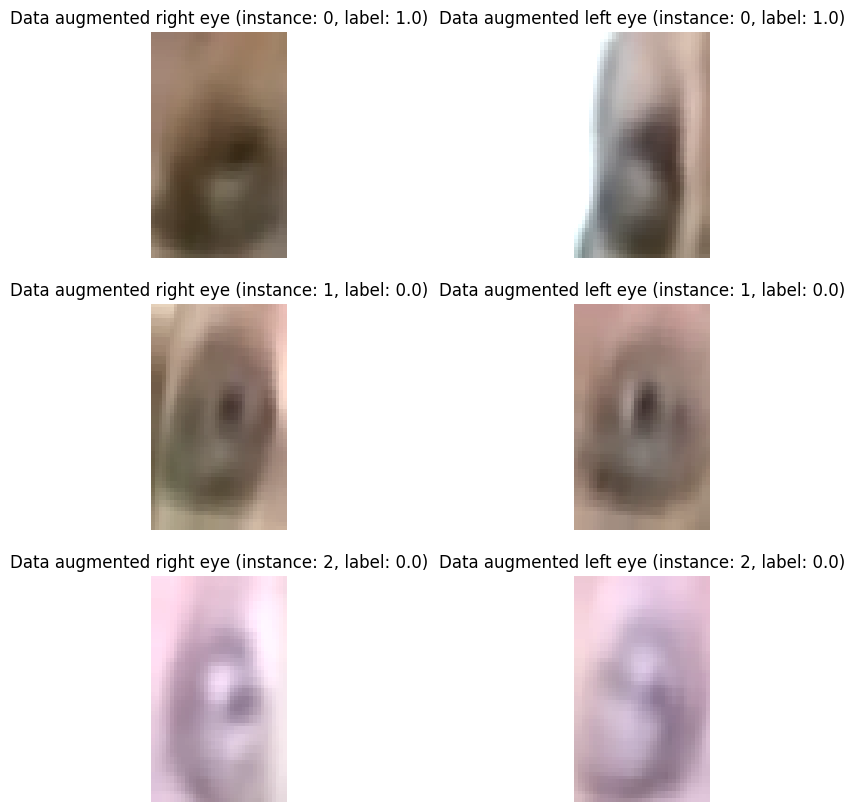

In [ ]:
aug_iter = generator(train_data_aug, aug_datagen)
fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(10,10))

for i in range(3):
  eye = next(aug_iter)
  left_eye_image = eye[0][0][i]
  right_eye_image = eye[0][1][i]

  ax[i,0].imshow(right_eye_image)
  ax[i,1].imshow(left_eye_image)
  ax[i,0].axis('off')
  ax[i,1].axis('off')

  ax[i,0].set_title(f'Data augmented right eye (instance: {i}, label: {eye[1][i]})')
  ax[i,1].set_title(f'Data augmented left eye (instance: {i}, label: {eye[1][i]})')

We define the network:

In [ ]:
input_shape = (60, 36, 3)
# Declaramos dos capas de Input
input_1 = Input(name='left_eye', shape=input_shape)
input_2 = Input(name='right_eye', shape=input_shape)

concat_layer= Concatenate(name='concat', axis=1)([input_1, input_2])

conv_1 = Conv2D(16, kernel_size=4, name='conv1',
                padding='same',strides=1, 
                input_shape=(img_width,img_height,3),
                activation='relu')(concat_layer)
dr_1 = Dropout(0.2)(conv_1)
max_1 = MaxPooling2D(pool_size=2, strides=2, name='max1', padding='same')(dr_1)
    
conv_2 = Conv2D(32, kernel_size=4, name='conv2',
                padding='same',strides=1,
                activation='relu')(max_1)
dr_2 = Dropout(0.2)(conv_2)
max_2 = MaxPooling2D(pool_size=3, strides=3, name='max2', padding='same')(dr_2)

conv_3 = Conv2D(32, kernel_size=4, name='conv3',
                padding='same',strides=1,
                activation='relu')(max_2)
dr_3 = Dropout(0.2)(conv_3)
max_3 = MaxPooling2D(pool_size=2, strides=2, name='max3', padding='same')(dr_3)

flat_layer = Flatten(name='flat')(max_3)

dense_1 = Dense(32, name='dense1', activation='relu')(flat_layer)
predictions = Dense(1, name='output', activation='sigmoid')(dense_1)


model = Model(inputs=[input_1, input_2], outputs=[predictions], name='blink_detector')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-3),
              metrics=tfa.metrics.F1Score(name='f1_score',num_classes=1,threshold=0.5,average='macro'))

In [ ]:
model.summary()

Model: "blink_detector"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_eye (InputLayer)          [(None, 60, 36, 3)]  0           []                               
                                                                                                  
 right_eye (InputLayer)         [(None, 60, 36, 3)]  0           []                               
                                                                                                  
 concat (Concatenate)           (None, 120, 36, 3)   0           ['left_eye[0][0]',               
                                                                  'right_eye[0][0]']              
                                                                                                  
 conv1 (Conv2D)                 (None, 120, 36, 16)  784         ['concat[0][0]']    

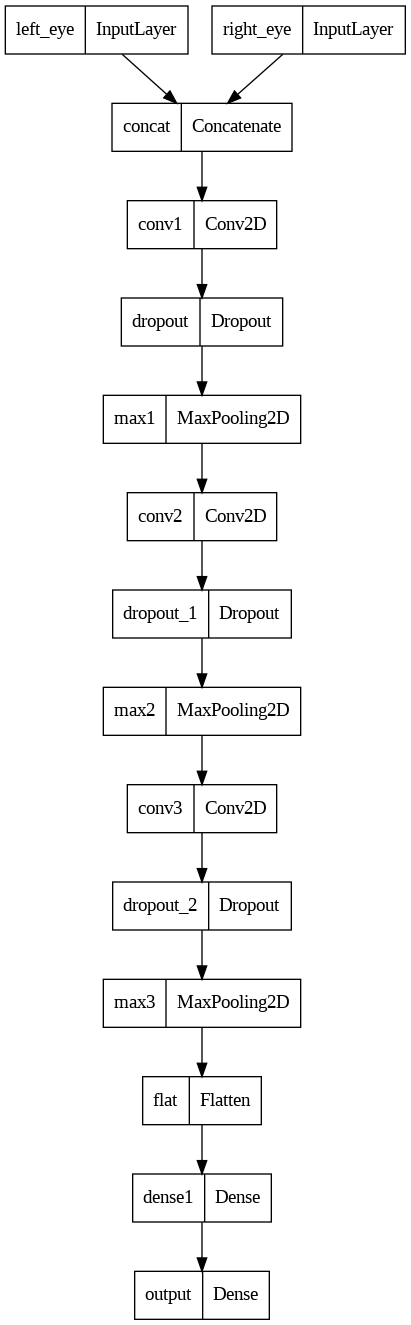

In [ ]:
keras.utils.plot_model(model, to_file='/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Trabajo final/model.png')

In [ ]:
## Function to show the training progress
def plot_history(history, title):
  fig, ax1 = plt.subplots()
  ax2 = ax1.twinx()

  ax1.plot(history.epoch, np.array(history.history['loss']), c='tab:blue', ls='--', label='Train Loss')
  ax1.plot(history.epoch, np.array(history.history['val_loss']), c='tab:blue', ls='-', label='Validation Loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('binary_crossentropy')

  ax2.plot(history.epoch, np.array(history.history['f1_score']), c='tab:orange',ls='--', label='Train F1-Score')
  ax2.plot(history.epoch, np.array(history.history['val_f1_score']), c='tab:orange', ls='-', label='Validation F1-Score')
  ax2.set_ylabel('f1_score')

  lines1, labels1 = ax1.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  lines = lines1 + lines2
  labels = labels1 + labels2
  ax1.legend(lines, labels, loc='best')

  plt.title("Training and validation performenace")
  fig.savefig(title)

To avoid overfitting, an early stopping is applied during the training. This will take the validation as reference metric to decide whether tos top the training of not, after 5 epochs of not improving it:

In [ ]:
# Definir el callback de EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Additionally, we use another callback to save the best F1-Score model:

In [ ]:
checkpoint_filepath = '/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Trabajo final/best_cnn.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_f1_score',
    mode='max',
    save_best_only=True)

On the other, a learning rate reduction is applied:

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)

We train the model and show its progress:

In [ ]:
# Entrenamos el modelo con los datos preparados en el punto 2
history = model.fit(train_generator,
                    epochs=30,
                    verbose=1,
                    steps_per_epoch=len(train_data)/batch_size,
                    validation_data=val_generator,
                    validation_steps=len(val_data)/batch_size,
                    callbacks=[early_stopping, model_checkpoint_callback, reduce_lr])

Found 143910 validated image filenames belonging to 2 classes.
Found 143910 validated image filenames belonging to 2 classes.
Epoch 1/30
1175/1174 [==============================] - ETA: 0s - loss: 0.2968 - f1_score: 0.8614Found 16102 validated image filenames belonging to 2 classes.
Found 16102 validated image filenames belonging to 2 classes.
1174/1174 [==============================] - 247s 201ms/step - loss: 0.2968 - f1_score: 0.8614 - val_loss: 0.1305 - val_f1_score: 0.5817 - lr: 0.0010
Epoch 2/30
1174/1174 [==============================] - 227s 194ms/step - loss: 0.1509 - f1_score: 0.9436 - val_loss: 0.1045 - val_f1_score: 0.6643 - lr: 0.0010
Epoch 3/30
1174/1174 [==============================] - 239s 204ms/step - loss: 0.1170 - f1_score: 0.9562 - val_loss: 0.1254 - val_f1_score: 0.6062 - lr: 0.0010
Epoch 4/30
1174/1174 [==============================] - 230s 196ms/step - loss: 0.0976 - f1_score: 0.9643 - val_loss: 0.0527 - val_f1_score: 0.8349 - lr: 0.0010
Epoch 5/30
1174/1174

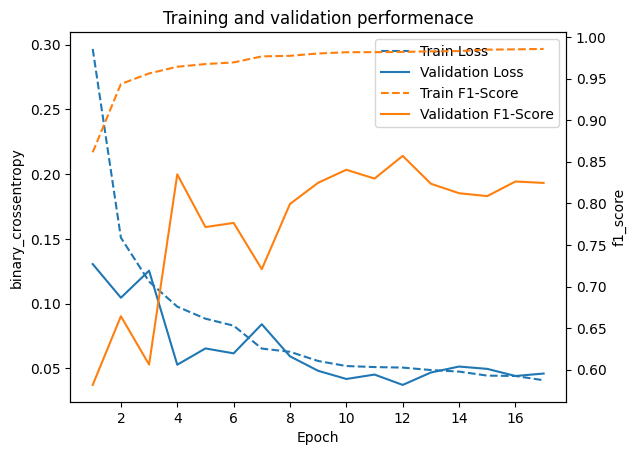

In [6]:
plot_history(history, "/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Trabajo final/cnn_training.png")

Finally, the model is evaluated:

In [ ]:
# Por último, podemos evaluar el modelo en el conjunto de test
model = load_model('/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Trabajo final/best_cnn.h5')
test_loss, test_f1 = model.evaluate(test_generator,
                                     batch_size=batch_size,
                                     steps=len(test_data)/batch_size,
                                     verbose=1)
print(f"Test loss: {test_loss}")
print(f"Test F1-Score: {test_f1}")

Found 16103 validated image filenames belonging to 2 classes.
Found 16103 validated image filenames belonging to 2 classes.
251/251 [==============================] - 14s 55ms/step - loss: 0.0396 - f1_score: 0.8520
Test loss: 0.03957245126366615
Test F1-Score: 0.8519948720932007




---



## 2. SECONDARY APPROACH - TRANSFER LEARNING

Now we use a pre-trained network on ImageNet (DenseNet121), that will be adapted to our problem by adding some layers in the input and output.

Only these additional llayers will be trained during the training phase.

In [ ]:
input_shape = (60, 36, 3)

base_model = applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(img_width*2,img_height,3))

for layer in base_model.layers:
    layer.trainable = False

input_1 = Input(name='left_eye', shape=input_shape)
input_2 = Input(name='right_eye', shape=input_shape)

concat_transfer = Concatenate(name='concat', axis=1)([input_1, input_2])
new_base = base_model(concat_transfer)

x = GlobalAveragePooling2D()(new_base)
x = Dense(1024, activation='relu')(x)
predictions_transfer = Dense(1, activation='sigmoid')(x) 

model_transfer = Model(inputs=[input_1, input_2], outputs=[predictions_transfer], name='blink_detector_transfer')

model_transfer.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-3),
              metrics=tfa.metrics.F1Score(name='f1_score',num_classes=1,threshold=0.5,average='macro'))

In [ ]:
model_transfer.summary()

Model: "blink_detector_transfer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_eye (InputLayer)          [(None, 60, 36, 3)]  0           []                               
                                                                                                  
 right_eye (InputLayer)         [(None, 60, 36, 3)]  0           []                               
                                                                                                  
 concat (Concatenate)           (None, 120, 36, 3)   0           ['left_eye[0][0]',               
                                                                  'right_eye[0][0]']              
                                                                                                  
 densenet121 (Functional)       (None, 3, 1, 1024)   7037504     ['concat[0]

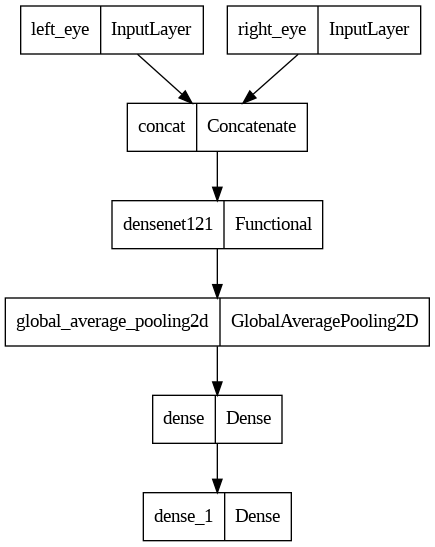

In [ ]:
keras.utils.plot_model(model_transfer, to_file='/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Trabajo final/model_transfer.png')

In [ ]:
early_stopping_transfer = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint_filepath_transfer = '/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Trabajo final/best_densenet121.h5'
model_checkpoint_callback_transfer = ModelCheckpoint(
    filepath=checkpoint_filepath_transfer,
    monitor='val_f1_score',
    mode='max',
    save_best_only=True)

In [ ]:
batch_size=128
history_transfer = model_transfer.fit(train_generator,
                    epochs=30,
                    verbose=1,
                    steps_per_epoch=len(train_data)/batch_size,
                    validation_data=val_generator,
                    validation_steps=len(val_data)/batch_size,
                    callbacks=[early_stopping_transfer, model_checkpoint_callback_transfer,reduce_lr])

Epoch 1/30
587/587 [==============================] - 135s 214ms/step - loss: 0.2813 - f1_score: 0.8880 - val_loss: 0.1945 - val_f1_score: 0.5032 - lr: 0.0010
Epoch 2/30
587/587 [==============================] - 123s 210ms/step - loss: 0.1824 - f1_score: 0.9266 - val_loss: 0.1493 - val_f1_score: 0.5496 - lr: 0.0010
Epoch 3/30
587/587 [==============================] - 126s 214ms/step - loss: 0.1564 - f1_score: 0.9380 - val_loss: 0.1338 - val_f1_score: 0.6093 - lr: 0.0010
Epoch 4/30
587/587 [==============================] - 124s 211ms/step - loss: 0.1366 - f1_score: 0.9470 - val_loss: 0.1437 - val_f1_score: 0.6037 - lr: 0.0010
Epoch 5/30
587/587 [==============================] - 126s 215ms/step - loss: 0.1240 - f1_score: 0.9528 - val_loss: 0.0850 - val_f1_score: 0.7063 - lr: 0.0010
Epoch 6/30
587/587 [==============================] - 120s 205ms/step - loss: 0.1195 - f1_score: 0.9537 - val_loss: 0.0905 - val_f1_score: 0.6997 - lr: 0.0010
Epoch 7/30
587/587 [==========================

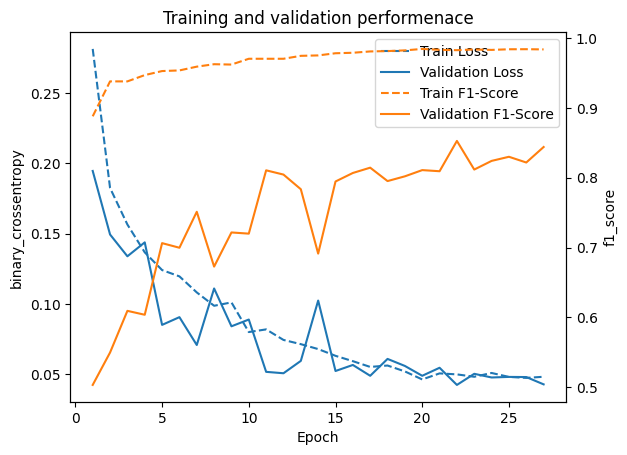

In [7]:
 # Mostramos la evolución de su entrenamiento
plot_history(history_transfer, "/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Trabajo final/transfer_training.png")

Finally, we evaluate the model:

In [ ]:
model_transfer = load_model('/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Trabajo final/best_densenet121.h5')
test_loss_transfer, test_f1_transfer = model_transfer.evaluate(test_generator,
                                                               steps=len(test_data)/batch_size,
                                                               verbose=1)
print(f"Test loss (transfer learning): {test_loss_transfer}")
print(f"Test F1-Score (transfer learning): {test_f1_transfer}")

125/125 [==============================] - 10s 63ms/step - loss: 0.0530 - f1_score: 0.8274
Test loss (transfer learning): 0.05302651226520538
Test F1-Score (transfer learning): 0.8274231553077698
